In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import torch.optim as optim
from torch import nn
from modules.BatchPitNormalization import BatchPitNorm1d

/tmp/ipykernel_142875/2839979308.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 20

train_data = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
test_data = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


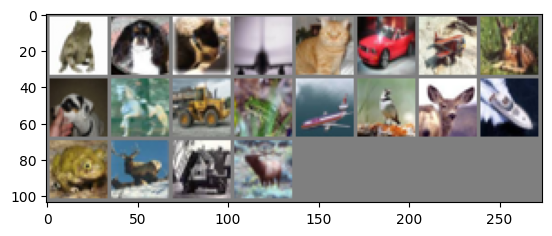

frog  dog   cat   plane cat   car   plane deer  dog   horse truck frog  plane bird  deer  ship  frog  deer  truck deer 


In [3]:

def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



dataiter = iter(trainloader)
images, labels = next(dataiter)


imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
input_size = 3*32*32
output_size = 10

class CIFAR10_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,92),
            #nn.BatchNorm1d(92),
            nn.ReLU(),
            nn.Linear(92,46),
            #nn.BatchNorm1d(46),
            nn.ReLU(),
            nn.Linear(46,output_size)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x



In [5]:
class CIFAR10_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            #nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 32, 5),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            #nn.Dropout(0.3),
            nn.Flatten(),
            #BatchPitNorm1d(num_features=32*5*5,num_pit_samples=32*5*5*3,dev=device,take_num_samples_when_full=0),
            nn.Linear(32 * 5 * 5, 120),
            #nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Linear(120, 42),
            #nn.BatchNorm1d(42),
            nn.ReLU(),
            nn.Linear(42,10)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [6]:
from sklearn.metrics import accuracy_score
model = CIFAR10_2()
lossfunction = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
n_epochs = 20


for epoch in range(n_epochs):
    train_loss = 0.0
    running_loss = 0.0
    model.to(device)
    model.train()
    for xbatch, ybatch in trainloader:
        xbatch, ybatch = xbatch.to(device), ybatch.to(device)
        y_pred = model(xbatch)
        loss = lossfunction(y_pred, ybatch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(loss.item())
        running_loss += loss.item()

    print(running_loss/len(trainloader.dataset))

correct = 0
total = 0
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Model Accuracy on test data :", 100 * correct // total)


print('Training Completed')

0.09497704448461533
0.07160349346160888
0.061674896146655084
0.05563654821038246
0.05080738977253437
0.04727075150042772
0.04405973824113608
0.041038128175139424
0.03829303177982569
0.035876507526934144
0.03355809701770544
0.031171667488217352
0.029122364697158336
0.02713667386800051
0.02551827091485262
0.023852422845736146
0.022272158464416863
0.020743088722620158
0.019358284703344105
0.01846545472934842
Model Accuracy on test data : 63
Training Completed
